### Review again the GPT architecture
![Screenshot 2024-12-05 at 01.09.58.png](<attachment:Screenshot 2024-12-05 at 01.09.58.png>)
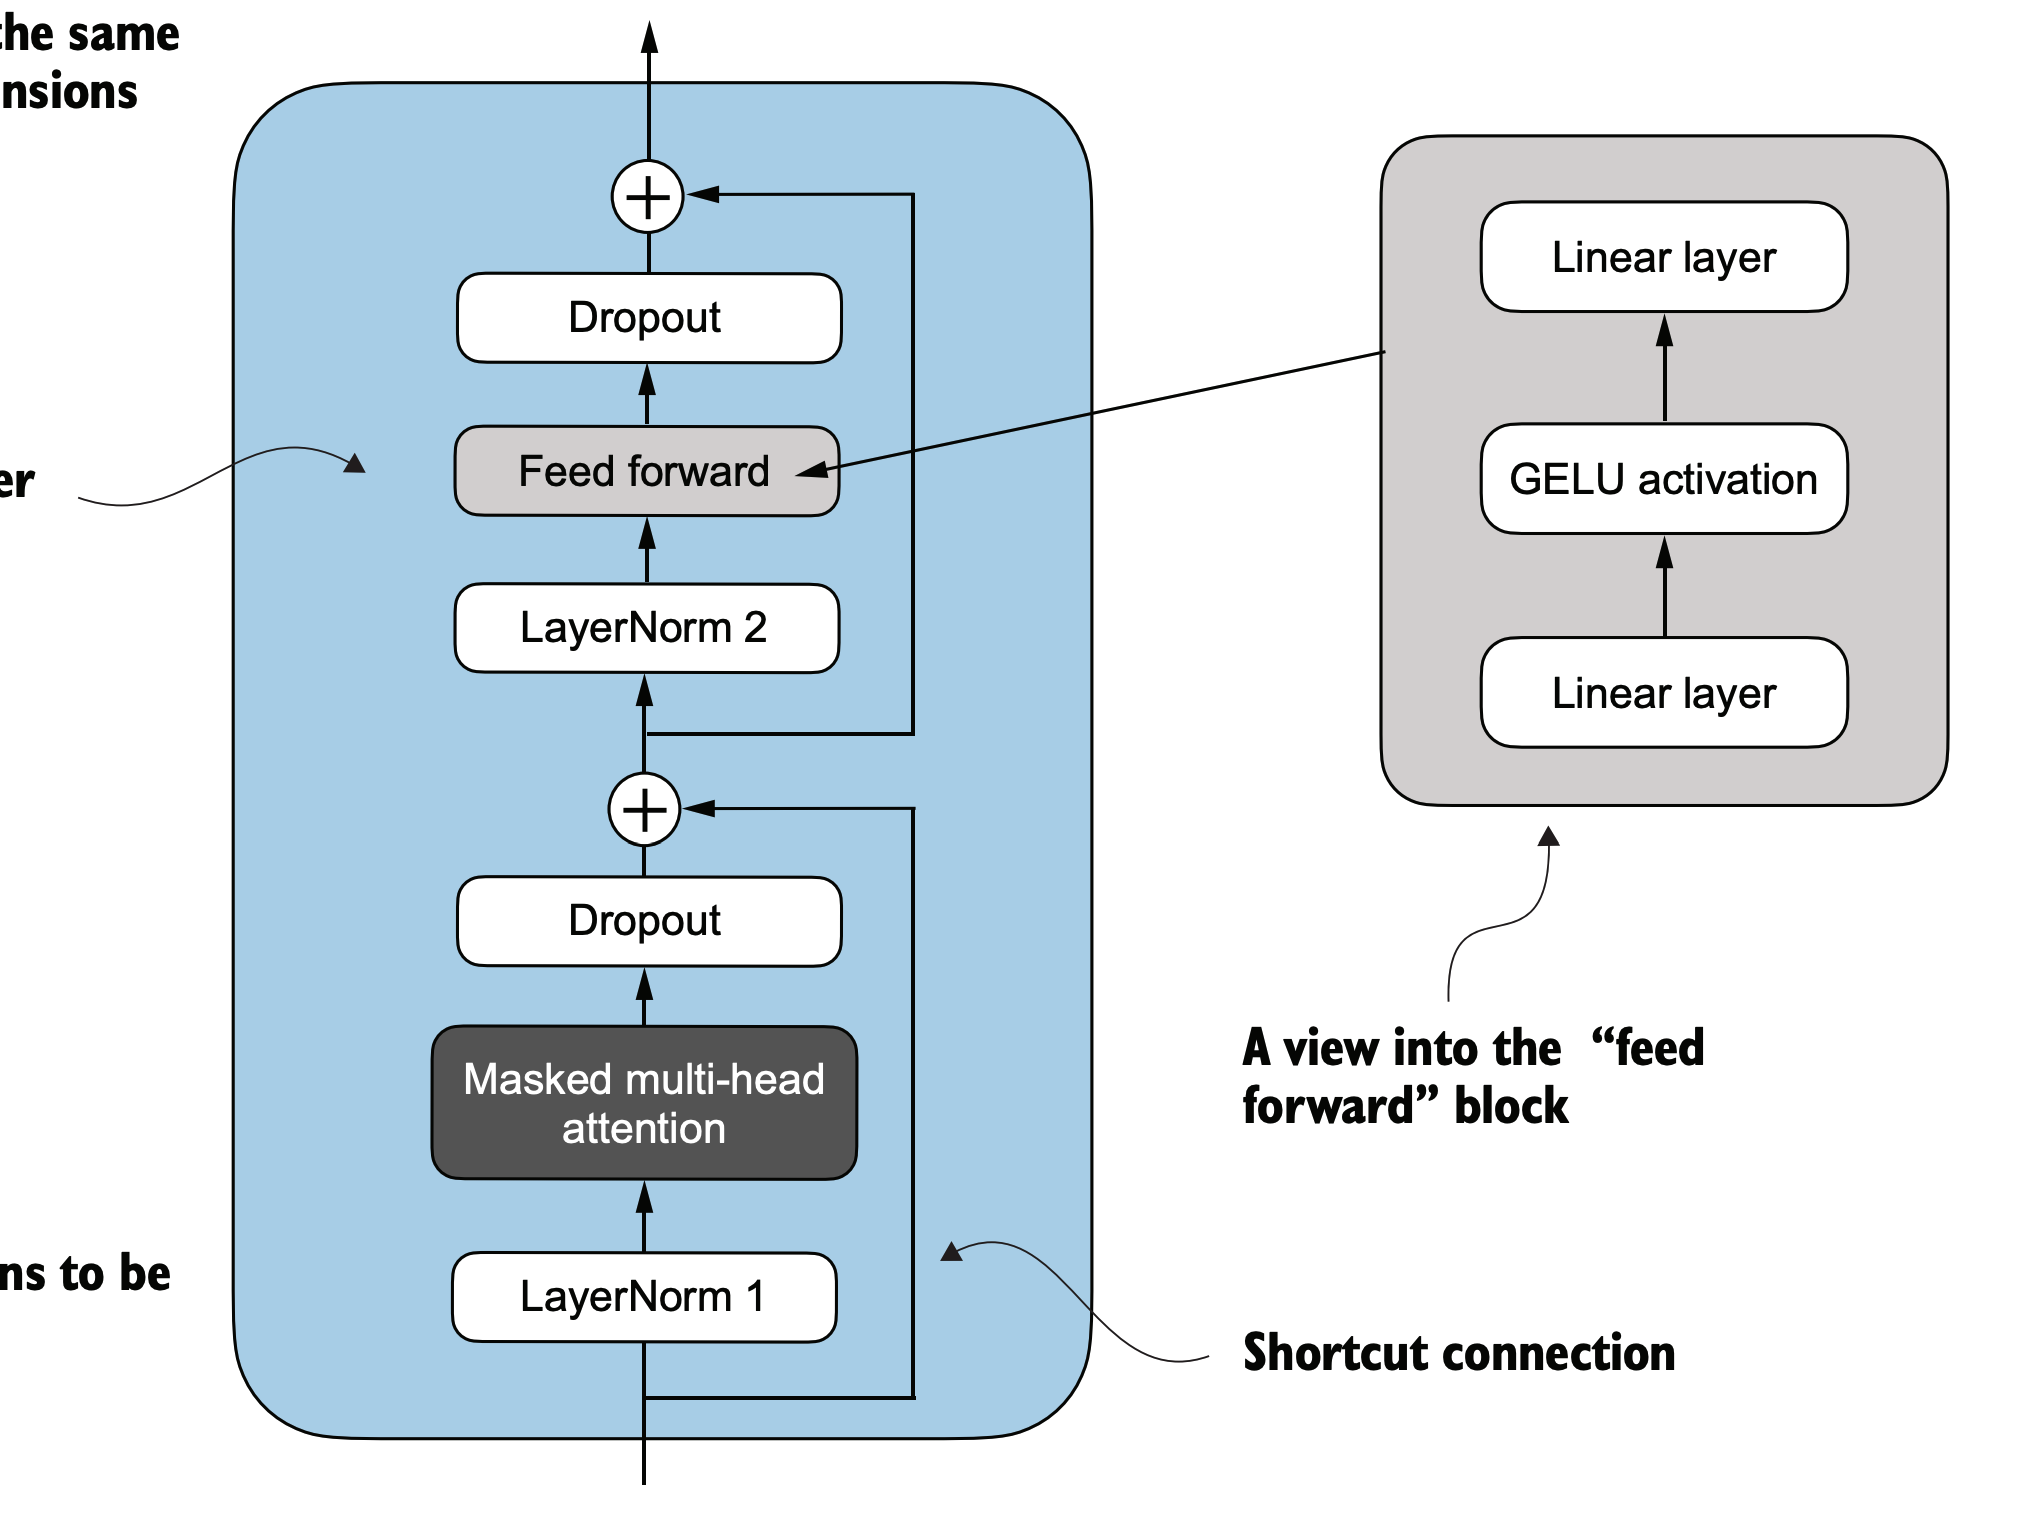

In [1]:
import torch
import torch.nn as nn

In [2]:
class MaskedMultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
        super().__init__()
        assert(d_out%num_heads==0), "d_out must devide into d_in"
        self.head_dim = d_out//num_heads
        self.W_q      = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_k      = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_v      = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.dropout  = nn.Dropout(p=dropout)
        self.projection = nn.Linear(d_out, d_out)
        self.num_heads= num_heads
        self.d_out    = d_out
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))
    def forward(self, x):
        batch_size, num_tokens, d_in = x.shape
        queries = self.W_q(x)
        keys    = self.W_k(x)
        values  = self.W_V(x)
        queries = queries.view(batch_size, num_tokens, self.num_heads,self.head_dim)
        keys    = keys.view(batch_size, num_tokens, self.num_heads,self.head_dim)
        values  = values.view(batch_size, num_tokens, self.num_heads,self.head_dim)
        queries.transpose(1,2)
        keys.transpose(1,2)
        values.transpose(1,2)
        attention_scores = queries@keys.transpose(2,3)
        mask_bool        = self.mask.bool()[:num_tokens,:num_tokens]
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        attenton_weights = torch.softmax(attention_scores/keys.shape[-1]**0.5)
        attenton_weights = self.dropout(attenton_weights)
        context_vec      = (attenton_weights@values).transpose(1,2)
        context_vec      = context_vec.contiguous().view(
            batch_size, num_tokens, self.d_out
        )
        context_vec      = self.projection(context_vec)
        return context_vec


In [3]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim) -> None:
        super().__init__()
        self.esp = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x:torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        var  = x.var(dim=-1,keepdim=True)
        normalization = (x-mean)/torch.sqrt(var+self.esp)
        return self.scale*normalization+self.shift

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg) -> None:
        super().__init__()
        self.Layer = nn.Sequential(
         nn.Linear(cfg["emb_size"],4*cfg["emb_size"]),
         nn.GELU(),
         nn.Linear(4*cfg["emb_size"],cfg["emb_size"])
    
        )
    def forward(self,x):
        return self.Layer(x)